<a href="https://colab.research.google.com/github/l-longo/neural-network-crash-course/blob/main/Intro_to_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**WORK IN PROGRESS**: do not circulate without the permission of the author.

(all the pictures imported in the notebook are from [Hand-on-ML](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)).

# Recurrent neural networks

Recurrent neural networks (RNN) are designed to predict sequences of arbitrary lenghts. In an RNN instances are *time steps t* (or *frame*) and previously generated output is fed into the network with the inputs to produce current output.

![picture](https://drive.google.com/uc?export=view&id=17vJomSBikJCQY7Yv4-8tQXCqmJTJUuA1)

In the picture above from the book we can see a simple recurrent neural network with 1 layer. We can *unroll* the network through time as on the right of the image to see that the previously generated output is fed into the network with the current input. If **x** is a scalar with one input we can represent the network as follows:

$$
y_{l,t} = \sigma(w_{l,1}x_t + w_{l,2}y_{l,t-1} + b) \ for \ l = 1,2,3,4
$$


The parts of RNN are also called *memory cells*.

## LSTM cell

The long-short-term memory (LSTM) RNN was designed by Hochreiter and Schmidhuber (1997). An LSTM cell can be represented as below: 

![picture](https://drive.google.com/uc?export=view&id=19DZdeeCHgKaQUA-NWR_JuD2dOpJs276q)

Three vectors are fed into an LSTM cell: current input vector $x_t$, previously generated output $h_{t-1}$ and a vector capturing the long-term memory component $c_{t-1}$. $c_{t}$ goes through the cell every time step dropping some memory.

In the cell there are four fully connected layers. The main  layer is the one that outputs $g_t$ and it has the standard layer that combines the vector of current input and previously generated output. The other three layers are gate controllers:

* *forget gate* is controlled by $f_t$ and controls which part of the long-term state should be erased;

* *input gate* is controlled by $i_t$ and controls which part of $g_t$ should be added to the long-term state;

* *output gate* is controlled by $o_t$ and defines which parts of the long-term state should be used for generating the current output.




## GRU cell

The gated recurrent unit (GRU) RNN was designed by Kyunghyun Cho et al. (2014) and follows the same concept of LSTM by capturing memory dependence in the data structure. A GRU cell can be represented as below:

![picture](https://drive.google.com/uc?export=view&id=15Kz3rMY4I8NVHJHHKYyhfnoRzC8_552J)

GRU cell differs with LSTM because the two state vectors are merged into one ($h_t$). There is one main layer and two control gates. The forget and input gates are merged in a single gate controller and there is no output gate: this gate is replaced by a new gate controller that controls which part of the previous state will be shown to the main layer.


## Implementing RNN with keras



In [ ]:
pip install shap

     |████████████████████████████████| 358kB 8.3MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491624 sha256=6ba7ed3220afc040351a0043760bbd56ab03cdd1579f0f8eaada8c77c4aba313
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
import os
import random as python_random
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from pandas import DataFrame
from numpy import concatenate
from pandas import concat
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from google.colab import files
import scipy
import shap

In [ ]:
os.environ['PYTHONHASHSEED']='34'
os.environ['CUDA_VISIBLE_DEVICE']=''
np.random.seed(100)
random.seed(30)
python_random.seed(30)
tf.random.set_seed(30)

In [ ]:
uploaded = files.upload()
df = pd.read_excel('fred_data.xlsx',index_col=0)
df

Saving fred_data.xlsx to fred_data.xlsx


,GDP,M1V,M2V,Unemp,infl,un,claims
1959-04-01,10.0,0.015172,0.008984,-0.143101,-0.001035,-0.130306,NaN
1959-05-01,NaN,NaN,NaN,-0.145712,0.001378,-0.130761,NaN
1959-06-01,NaN,NaN,NaN,-0.113329,0.004821,-0.102996,NaN
1959-07-01,1.8,-0.002423,-0.008984,-0.019418,0.005849,-0.012115,NaN
1959-08-01,NaN,NaN,NaN,0.019418,0.004809,0.030850,NaN
...,...,...,...,...,...,...,...
2020-09-01,NaN,NaN,NaN,-0.352821,0.011082,-0.344870,-0.527027
2020-10-01,6.3,-0.021872,-0.011389,-0.390866,0.007159,-0.389316,-0.487995
2020-11-01,NaN,NaN,NaN,-0.226124,0.005442,-0.232939,-0.172678
2020-12-01,NaN,NaN,NaN,-0.152016,0.005409,-0.154922,-0.046912


## Data pre-processing

As one can notice, variables are measured at different frequencies: we need to make a choice on how to handle missing values. We can use *downsampling* or *upsampling*. With the downsampling the missing values are cancelled from the dataset and the higher frequency variables are aggregated to match the same frequency. With the upsampling we impute values to fill the "gaps" in the dataset. For this particular application, upsampling is used in order to have more observations and missing values are filled by linear interpolation:

In [ ]:
dff = df.interpolate()
dff

,GDP,M1V,M2V,Unemp,infl,un,claims
1959-04-01,10.000000,0.015172,0.008984,-0.143101,-0.001035,-0.130306,NaN
1959-05-01,7.266667,0.009307,0.002995,-0.145712,0.001378,-0.130761,NaN
1959-06-01,4.533333,0.003442,-0.002995,-0.113329,0.004821,-0.102996,NaN
1959-07-01,1.800000,-0.002423,-0.008984,-0.019418,0.005849,-0.012115,NaN
1959-08-01,2.100000,0.003644,-0.004863,0.019418,0.004809,0.030850,NaN
...,...,...,...,...,...,...,...
2020-09-01,16.966667,-0.087892,0.005737,-0.352821,0.011082,-0.344870,-0.527027
2020-10-01,6.300000,-0.021872,-0.011389,-0.390866,0.007159,-0.389316,-0.487995
2020-11-01,7.766667,-0.020920,-0.011135,-0.226124,0.005442,-0.232939,-0.172678
2020-12-01,9.233333,-0.019968,-0.010882,-0.152016,0.005409,-0.154922,-0.046912


We now have filled missing values by linear interpolation.

Notice that there are still missing values for the variables *claims*: this is because this variables was started to be measured later in the FRED dataset and it was not filled with linear interpolation because it has any value in its first row. Here zeros will be imputed: with this choice we would like to have a model that "understands" that the variables start to be measured later.

In [ ]:
dff = dff.fillna(0)
dff

,GDP,M1V,M2V,Unemp,infl,un,claims
1959-04-01,10.000000,0.015172,0.008984,-0.143101,-0.001035,-0.130306,0.000000
1959-05-01,7.266667,0.009307,0.002995,-0.145712,0.001378,-0.130761,0.000000
1959-06-01,4.533333,0.003442,-0.002995,-0.113329,0.004821,-0.102996,0.000000
1959-07-01,1.800000,-0.002423,-0.008984,-0.019418,0.005849,-0.012115,0.000000
1959-08-01,2.100000,0.003644,-0.004863,0.019418,0.004809,0.030850,0.000000
...,...,...,...,...,...,...,...
2020-09-01,16.966667,-0.087892,0.005737,-0.352821,0.011082,-0.344870,-0.527027
2020-10-01,6.300000,-0.021872,-0.011389,-0.390866,0.007159,-0.389316,-0.487995
2020-11-01,7.766667,-0.020920,-0.011135,-0.226124,0.005442,-0.232939,-0.172678
2020-12-01,9.233333,-0.019968,-0.010882,-0.152016,0.005409,-0.154922,-0.046912


### Data visualization and correlation

Now we have two dataset: one real dataset with missing values and one "artificial" one that we need to train the RNN. We can make some data visualization by plotting the variables:

<Figure size 432x288 with 0 Axes>

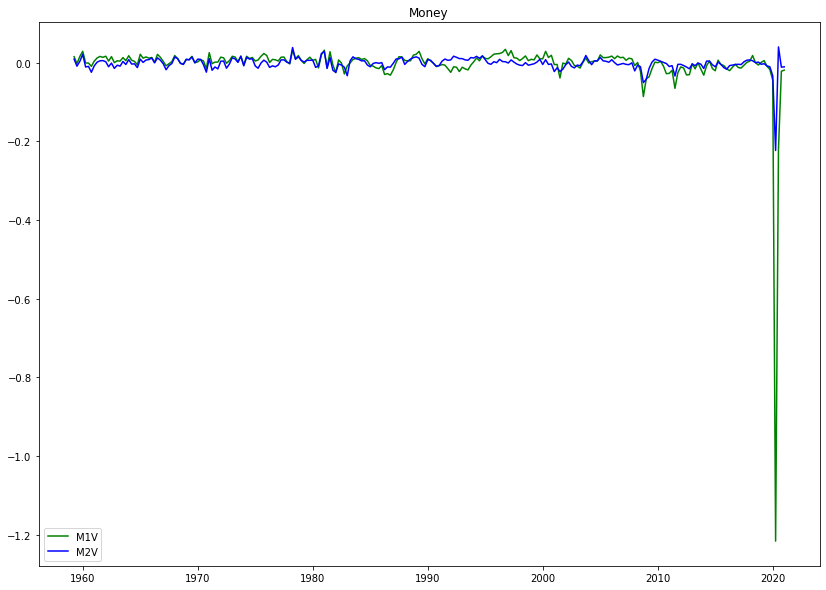

In [ ]:
fig = plt.figure()
plt.figure(figsize=(14, 10))
plt.plot(df.M1V.dropna(), 'green', label='M1V')
plt.plot(df.M2V.dropna(),'blue', label='M2V')
plt.legend()
plt.title('Money')
plt.show()

<Figure size 432x288 with 0 Axes>

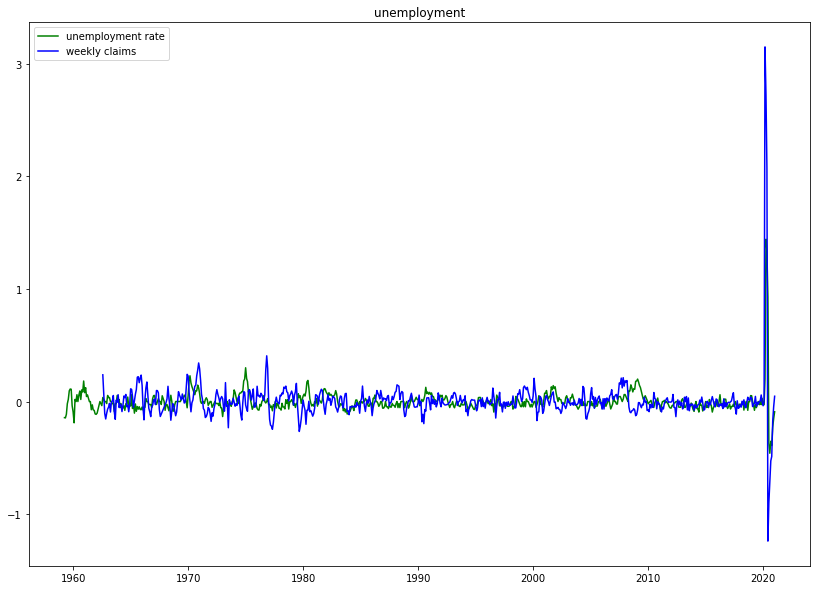

In [ ]:
fig = plt.figure()
plt.figure(figsize=(14, 10))
plt.plot(df.Unemp, 'green', label='unemployment rate')
plt.plot(df.claims,'blue', label='weekly claims')
plt.legend()
plt.title('unemployment')
plt.show()

<Figure size 432x288 with 0 Axes>

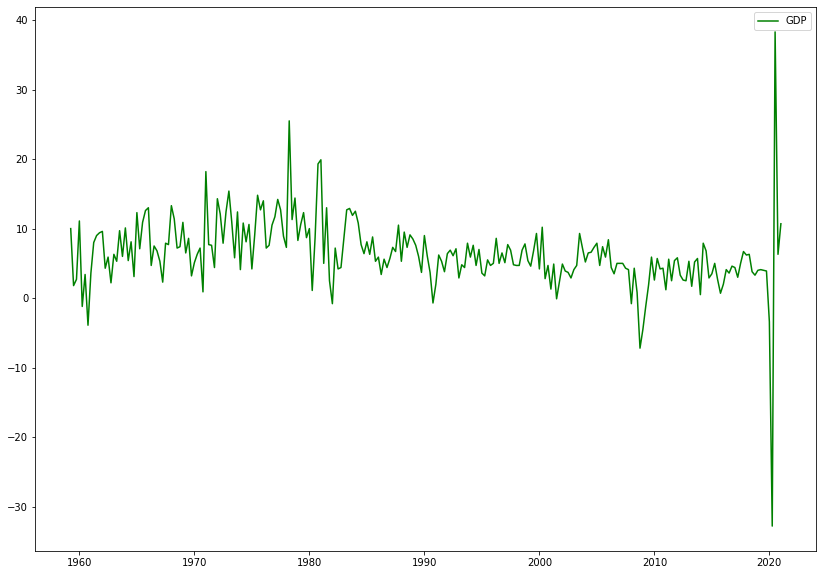

In [ ]:
fig = plt.figure()
plt.figure(figsize=(14, 10))
plt.plot(df.GDP.dropna(), 'green', label='GDP')
plt.legend()
plt.title('')
plt.show()

We may also want to look at empirical correlation:

In [ ]:
df_corr = df.dropna()
c1 = scipy.stats.pearsonr(df_corr.GDP,df_corr.Unemp)[0]
pv = scipy.stats.pearsonr(df_corr.GDP,df_corr.Unemp)[1]
print( 'correlation between GDP and unemployment:', c1, '\n', 'P-value:', pv)

correlation between GDP and unemployment: -0.6118387668628827 
 P-value: 2.0126018947568847e-25


In [ ]:
c1 = scipy.stats.pearsonr(df_corr.claims,df_corr.Unemp)[0]
pv = scipy.stats.pearsonr(df_corr.claims,df_corr.Unemp)[1]
print( 'correlation between weekly claims and unemployment:', c1, '\n', 'P-value:', pv)

correlation between weekly claims and unemployment: 0.8038047864045926 
 P-value: 3.036743580898015e-54


In [ ]:
c1 = scipy.stats.pearsonr(df_corr.claims[:-1],df_corr.GDP[1:])[0]
pv = scipy.stats.pearsonr(df_corr.claims[:-1],df_corr.GDP[1:])[1]
print( 'correlation between weekly claims and unemployment:', c1, '\n', 'P-value:', pv)

correlation between weekly claims and unemployment: 0.36971152391552314 
 P-value: 5.863938863375374e-09


In [ ]:
df = df[df.index < "2019-01-01"]
dff = dff[dff.index < "2019-01-01"]

### Prepare model's features

We now use a function from [Machine Learning Mastery](https://machinelearningmastery.com/) to prepare the data input and output of the model. In particular we want to use lagged macroeconomic variables to predict the actual GDP:

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

We transform the dataframe in a numpy array and we apply the data transformation with the MinMaxScaler:

In [ ]:
values = dff.to_numpy()
#values = values.astype('float32')
values.dtype
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
lag = 1
n_features = values.shape[1]
# frame as supervised learning
reframed = series_to_supervised(scaled, lag, 3)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var5(t+1),var6(t+1),var7(t+1),var1(t+2),var2(t+2),var3(t+2),var4(t+2),var5(t+2),var6(t+2),var7(t+2)
1,0.525994,0.844192,0.670245,0.094291,0.446570,0.110230,0.395543,0.442406,0.795365,0.603031,0.088956,0.478514,0.109302,0.395543,0.358818,0.746538,0.535817,0.155132,0.524089,0.165910,0.395543,0.275229,0.697710,0.468604,0.347042,0.537699,0.351197,0.395543
2,0.442406,0.795365,0.603031,0.088956,0.478514,0.109302,0.395543,0.358818,0.746538,0.535817,0.155132,0.524089,0.165910,0.395543,0.275229,0.697710,0.468604,0.347042,0.537699,0.351197,0.395543,0.284404,0.748218,0.514848,0.426406,0.523935,0.438793,0.395543
3,0.358818,0.746538,0.535817,0.155132,0.524089,0.165910,0.395543,0.275229,0.697710,0.468604,0.347042,0.537699,0.351197,0.395543,0.284404,0.748218,0.514848,0.426406,0.523935,0.438793,0.395543,0.293578,0.798725,0.561093,0.581494,0.523783,0.571888,0.395543
4,0.275229,0.697710,0.468604,0.347042,0.537699,0.351197,0.395543,0.284404,0.748218,0.514848,0.426406,0.523935,0.438793,0.395543,0.293578,0.798725,0.561093,0.581494,0.523783,0.571888,0.395543,0.302752,0.849232,0.607338,0.614018,0.550787,0.585496,0.395543
5,0.284404,0.748218,0.514848,0.426406,0.523935,0.438793,0.395543,0.293578,0.798725,0.561093,0.581494,0.523783,0.571888,0.395543,0.302752,0.849232,0.607338,0.614018,0.550787,0.585496,0.395543,0.388379,0.885279,0.673764,0.609877,0.537169,0.599040,0.395543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,0.387360,0.818279,0.605357,0.231444,0.538943,0.254479,0.418021,0.361876,0.768080,0.587390,0.386724,0.546731,0.354768,0.327124,0.336391,0.717881,0.569424,0.281904,0.516745,0.240473,0.313810,0.331295,0.701084,0.574542,0.386724,0.510268,0.362058,0.381751
711,0.361876,0.768080,0.587390,0.386724,0.546731,0.354768,0.327124,0.336391,0.717881,0.569424,0.281904,0.516745,0.240473,0.313810,0.331295,0.701084,0.574542,0.386724,0.510268,0.362058,0.381751,0.326198,0.684287,0.579659,0.227406,0.514501,0.246681,0.452213
712,0.336391,0.717881,0.569424,0.281904,0.516745,0.240473,0.313810,0.331295,0.701084,0.574542,0.386724,0.510268,0.362058,0.381751,0.326198,0.684287,0.579659,0.227406,0.514501,0.246681,0.452213,0.321101,0.667489,0.584776,0.386724,0.541865,0.387173,0.416401
713,0.331295,0.701084,0.574542,0.386724,0.510268,0.362058,0.381751,0.326198,0.684287,0.579659,0.227406,0.514501,0.246681,0.452213,0.321101,0.667489,0.584776,0.386724,0.541865,0.387173,0.416401,0.328236,0.686268,0.564286,0.386724,0.517308,0.358632,0.414475


We then split the data in train and validation set (note that we do not randomize here because of the time structure) and generate 3-D arrays that will be fed into the model: indeed RNN such as LSTM and GRU expects input in the data format (samples, steps, features).

In [ ]:
# split into train and validation sets
values = reframed.values
train_obs = np.around(np.size(values[:,0])*0.8).astype(int)
train = values[:train_obs, :]
val = values[train_obs:np.around(np.size(values[:,0])*0.8).astype(int), :]
T=np.size(train[:,0])
Ts=np.size(val[:,0])
n_obs = lag * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
val_X, val_y = val[:, :n_obs], val[:, -n_features]
print(train_X.shape, train_y.shape)
# reshape input to be 3D [samples, timesteps backwards, features]
train_X = train_X.reshape((train_X.shape[0], lag, n_features))
val_X = val_X.reshape((val_X.shape[0], lag, n_features))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

(571, 7) (571,)
(571, 1, 7) (571,) (0, 1, 7) (0,)


## RNN prediction

Epoch 1/100
5/5 [==============================] - 24s 219ms/step - loss: 0.4862 - val_loss: 0.2603
Epoch 2/100
5/5 [==============================] - 0s 9ms/step - loss: 0.2908 - val_loss: 0.1192
Epoch 3/100
5/5 [==============================] - 0s 10ms/step - loss: 0.1577 - val_loss: 0.0982
Epoch 4/100
5/5 [==============================] - 0s 11ms/step - loss: 0.1187 - val_loss: 0.1252
Epoch 5/100
5/5 [==============================] - 0s 10ms/step - loss: 0.1118 - val_loss: 0.0946
Epoch 6/100
5/5 [==============================] - 0s 10ms/step - loss: 0.0933 - val_loss: 0.0604
Epoch 7/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0925 - val_loss: 0.0562
Epoch 8/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0964 - val_loss: 0.0531
Epoch 9/100
5/5 [==============================] - 0s 9ms/step - loss: 0.0893 - val_loss: 0.0588
Epoch 10/100
5/5 [==============================] - 0s 11ms/step - loss: 0.0859 - val_loss: 0.0639
Epoch 11/100
5/5 [==

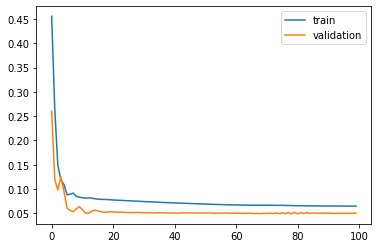

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='selu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(20, activation = 'selu'))
model.add(Dense(3, activation = 'selu'))   
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=100, validation_split=0.2, verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [ ]:
test = values[np.around(np.size(values[:,0])*0.8).astype(int):np.size(values[:,0]), :]
Te=np.size(test[:,0])
test_X, test_y = test[:, :n_obs], test[:, -n_features]
test_X = test_X.reshape((test_X.shape[0], lag, n_features))

# make a prediction
yhat = model.predict(test_X)

We now have to rescale the predicted output into the original official GDP scale. We do the same for the actual output:

In [ ]:
# invert scaling for predited
yhat1=np.array([yhat[:,0]]).T
test_X = test_X.reshape((test_X.shape[0], lag*n_features))
inv_yhat1 = concatenate((yhat1, test_X[:, -(n_features-1):]), axis=1)
inv_yhat1 = scaler.inverse_transform(inv_yhat1)
inv_yhat1 = inv_yhat1[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0] 

And we can then visualize the prediction in the test set:

<Figure size 432x288 with 0 Axes>

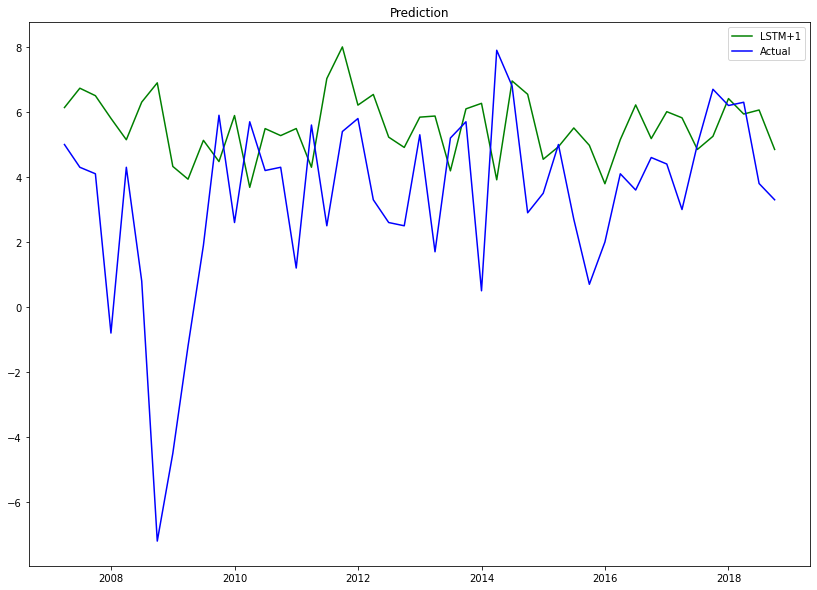

In [ ]:
test_df = df.iloc[-np.size(inv_y):]
test_df.insert(loc=0,column='pred',value=inv_yhat1)
test_df = test_df.dropna()

fig = plt.figure()
plt.figure(figsize=(14, 10))
plt.plot(test_df.pred, 'green', label='LSTM+1')
plt.plot(test_df.GDP,'blue', label='Actual')
plt.legend()
plt.title('Prediction')
plt.show()

In [ ]:
print('RMSE:')
print(sqrt(mean_squared_error(test_df.pred,test_df.GDP))) 

RMSE:
3.6666036418272294


## SHAP values in RNN

We can compute SHAP values with the gradient explainer method. More details can be found at [GradientExplainer](https://distill.pub/2020/attribution-baselines/). The intuition is because the gradient of the function's model tells us which features has the steepest local slope with respect to the output.

In [ ]:
test_X = test_X.reshape((test_X.shape[0], lag, n_features))

In [ ]:
shap.initjs()
explainer = shap.GradientExplainer(model, train_X)
shap_values = explainer.shap_values(test_X)
c = np.array([shap_values])[0,2,:,0,:]

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


With this method we compute SHAP values for the whole test set:

In [ ]:
pd.DataFrame(c, columns=list(df.columns))

,GDP,M1V,M2V,Unemp,infl,un,claims
0,-0.051346,-0.003613,0.013111,0.006543,-0.020761,-0.009684,0.007710
1,-0.053309,-0.003486,0.009612,0.002837,-0.009124,-0.004544,0.001603
2,-0.043032,-0.003904,0.005483,-0.008465,-0.003393,0.012047,-0.000789
3,-0.052106,-0.002267,0.012827,-0.001041,-0.000145,0.000782,0.001347
4,-0.053701,-0.000416,0.012464,0.000046,-0.000807,-0.003494,0.002732
...,...,...,...,...,...,...,...
138,-0.035455,-0.002414,-0.006441,0.012040,-0.003700,-0.017376,0.001198
139,-0.052621,-0.000586,-0.005214,-0.001905,-0.004462,-0.004205,-0.004343
140,-0.079739,0.002951,0.002502,0.008099,-0.007075,-0.021299,-0.005311
141,-0.076222,0.002428,0.002877,-0.002158,-0.005733,-0.002813,-0.001708


In [ ]:
shap_df = pd.DataFrame(c, columns=list(df.columns))

We can plot the SHAP values for each feature over time:

In [ ]:
shap_df.insert(0, 'example', np.array([df.iloc[-np.size(inv_y):,0]]).T)
shap_df = shap_df.dropna()
shap_df.index = test_df.index

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

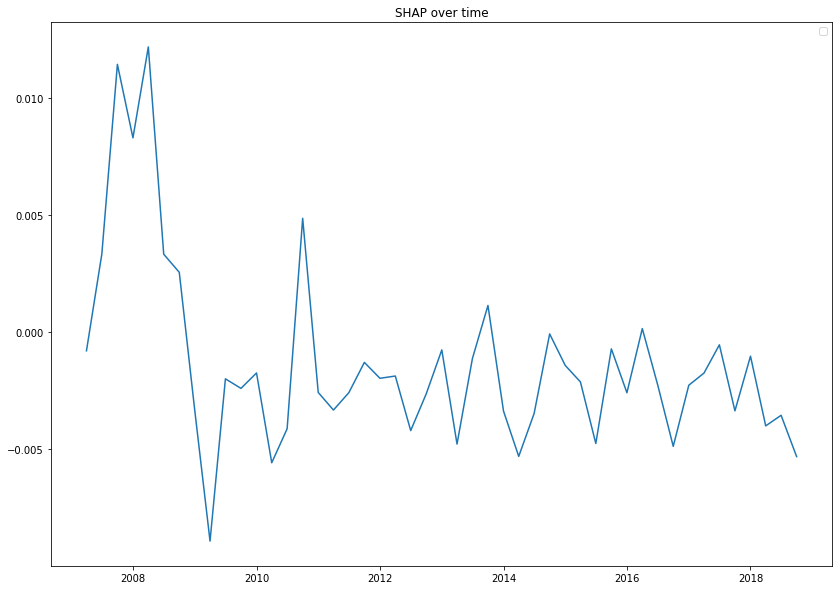

In [ ]:
fig = plt.figure()
plt.figure(figsize=(14, 10))
plt.plot(shap_df.claims)
plt.legend()
plt.title('SHAP over time')
plt.show()

In [ ]:
from itertools import repeat, chain
revert_dict = lambda d: dict(chain(*[zip(val, repeat(key)) for key, val in d.items()]))
        
def grouped_shap(shap_vals, features, groups):
    groupmap = revert_dict(groups)
    shap_Tdf = pd.DataFrame(shap_vals, columns=pd.Index(features, name='features')).T
    shap_Tdf['group'] = shap_Tdf.reset_index().features.map(groupmap).values
    shap_grouped = shap_Tdf.groupby('group').sum().T
    return shap_grouped

In [ ]:
groups_by_type = {
    'A': ['GDP', 'M1V', 'M2V'],
    'B': ['Unemp', 'infl', 'un', 'claims']
}

In [ ]:
shap_type50 = grouped_shap(c, list(df.columns), groups_by_type)

In [ ]:
shap_type50

group,A,B
0,-0.041848,-0.016192
1,-0.047183,-0.009229
2,-0.041453,-0.000600
3,-0.041546,0.000943
4,-0.041653,-0.001523
...,...,...
138,-0.044310,-0.007838
139,-0.058421,-0.014916
140,-0.074285,-0.025586
141,-0.070916,-0.012411


<Figure size 432x288 with 0 Axes>

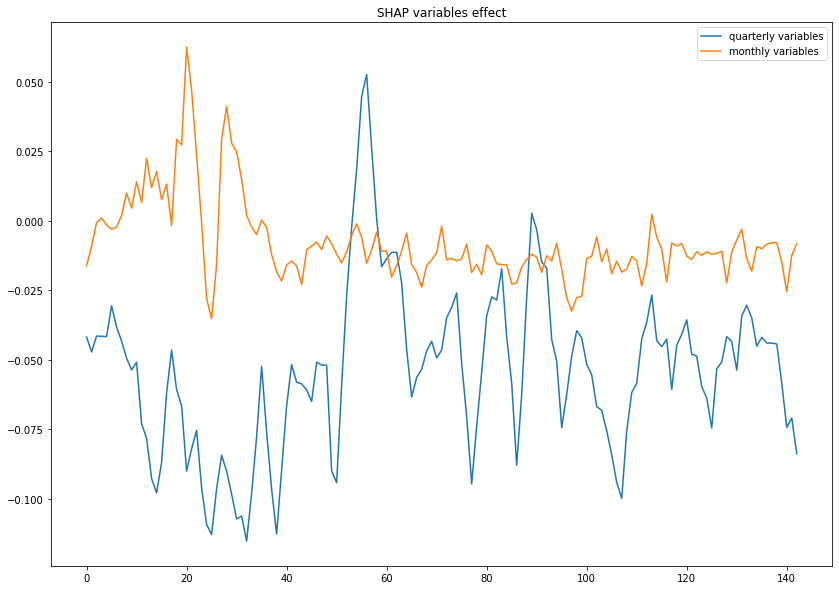

In [ ]:
fig = plt.figure()
plt.figure(figsize=(14, 10))
plt.plot(shap_type50.A, label = 'quarterly variables')
plt.plot(shap_type50.B, label = 'monthly variables')
plt.legend()
plt.title('SHAP variables effect')
plt.show()